In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import CubicHermiteSpline
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from financepy.utils import *
from financepy.products.rates import *
from tqdm import tqdm
import pickle
from seaborn import heatmap

## Prerequisite: Convert Bloomberg data into benchmark

In [11]:
# read dataset
df = pd.read_excel('gbp_ois_data_cw.xlsx',sheet_name='gbp ois results condensed copy')
df.dropna(inplace=True) # dates where all benchmark instruments are available
# convert date to format dd-mm-yyyy
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)
# convert to float
df = df.astype(np.float32)
# rename columns
columns = ['1W','2W']
for i in [1,2,5,6,7,8,9,10,11]:
    columns.append(str(i)+'M')
columns.append('1Y')
columns.append('18M')
for i in [2,3,4,5,6,7,8,9,10,12,15,20,25,30,40,50]:
    columns.append(str(i)+'Y')
# convert df.columns to columns
for i in zip(df.columns, columns):
    df.rename(columns={i[0]:i[1]}, inplace=True)
df.head()

,1W,2W,1M,2M,5M,6M,7M,8M,9M,10M,...,8Y,9Y,10Y,12Y,15Y,20Y,25Y,30Y,40Y,50Y
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-27,0.19560,0.38050,0.38050,0.4339,0.61670,0.6738,0.7420,0.79440,0.84270,0.89160,...,1.18400,1.17000,1.15820,1.1314,1.1148,1.0665,1.02200,0.9812,0.89275,0.80450
2022-01-28,0.22930,0.38450,0.38450,0.4375,0.63216,0.6910,0.7589,0.81300,0.86277,0.91184,...,1.20635,1.19205,1.18135,1.1593,1.1387,1.0938,1.05250,1.0158,0.92410,0.83600
2022-01-31,0.33260,0.41175,0.41175,0.4710,0.66400,0.7230,0.7967,0.85310,0.90340,0.95515,...,1.25550,1.23790,1.22800,1.2130,1.1860,1.1440,1.10225,1.0670,0.98105,0.89615
2022-02-01,0.36900,0.42165,0.42165,0.4770,0.66610,0.7255,0.7940,0.85360,0.89930,0.94730,...,1.24800,1.23400,1.22400,1.2038,1.1779,1.1330,1.09200,1.0560,0.96620,0.88300
2022-02-02,0.40855,0.43415,0.43415,0.4900,0.67320,0.7258,0.7908,0.84631,0.89184,0.93803,...,1.22300,1.20800,1.19700,1.1750,1.1470,1.0960,1.05100,1.0110,0.92025,0.83355


## Compare curves - zero rates interpolation or log discount rates interpolation

Day 1

In [12]:
# Demonstrate fitting a curve using the first date
valuation_date = Date(df.index[0].day, df.index[0].month, df.index[0].year)
spot_days = 0 # T+0 as shown in Bloomberg ticker
settlement_date = valuation_date.add_weekdays(spot_days)
cal = CalendarTypes.UNITED_KINGDOM
# store SONIA swap as we only have swap as benchmark instruments
swaps = []
swapType = SwapTypes.PAY # pay fixed
fixedDCCType = DayCountTypes.ACT_365F # 365 fixed
fixedFreqType = FrequencyTypes.ANNUAL # annual
floatFreqType = FrequencyTypes.ANNUAL # annual
floatDCCType = DayCountTypes.ACT_365F # 365 fixed

# Only use years
for tenor in df.columns:
   if tenor[-1]=='Y': # only ap}pend yearly tenors for swap
      rate = df.loc[df.index[0], tenor]/100 # convert to %
      swap = IborSwap(effective_date=settlement_date, termination_date_or_tenor=tenor,
                      fixed_leg_type=swapType, fixed_coupon=rate, fixed_freq_type=fixedFreqType, fixed_day_count_type=fixedDCCType,
                      float_freq_type=floatFreqType, float_day_count_type=floatDCCType, calendar_type=cal)
      swaps.append(swap)


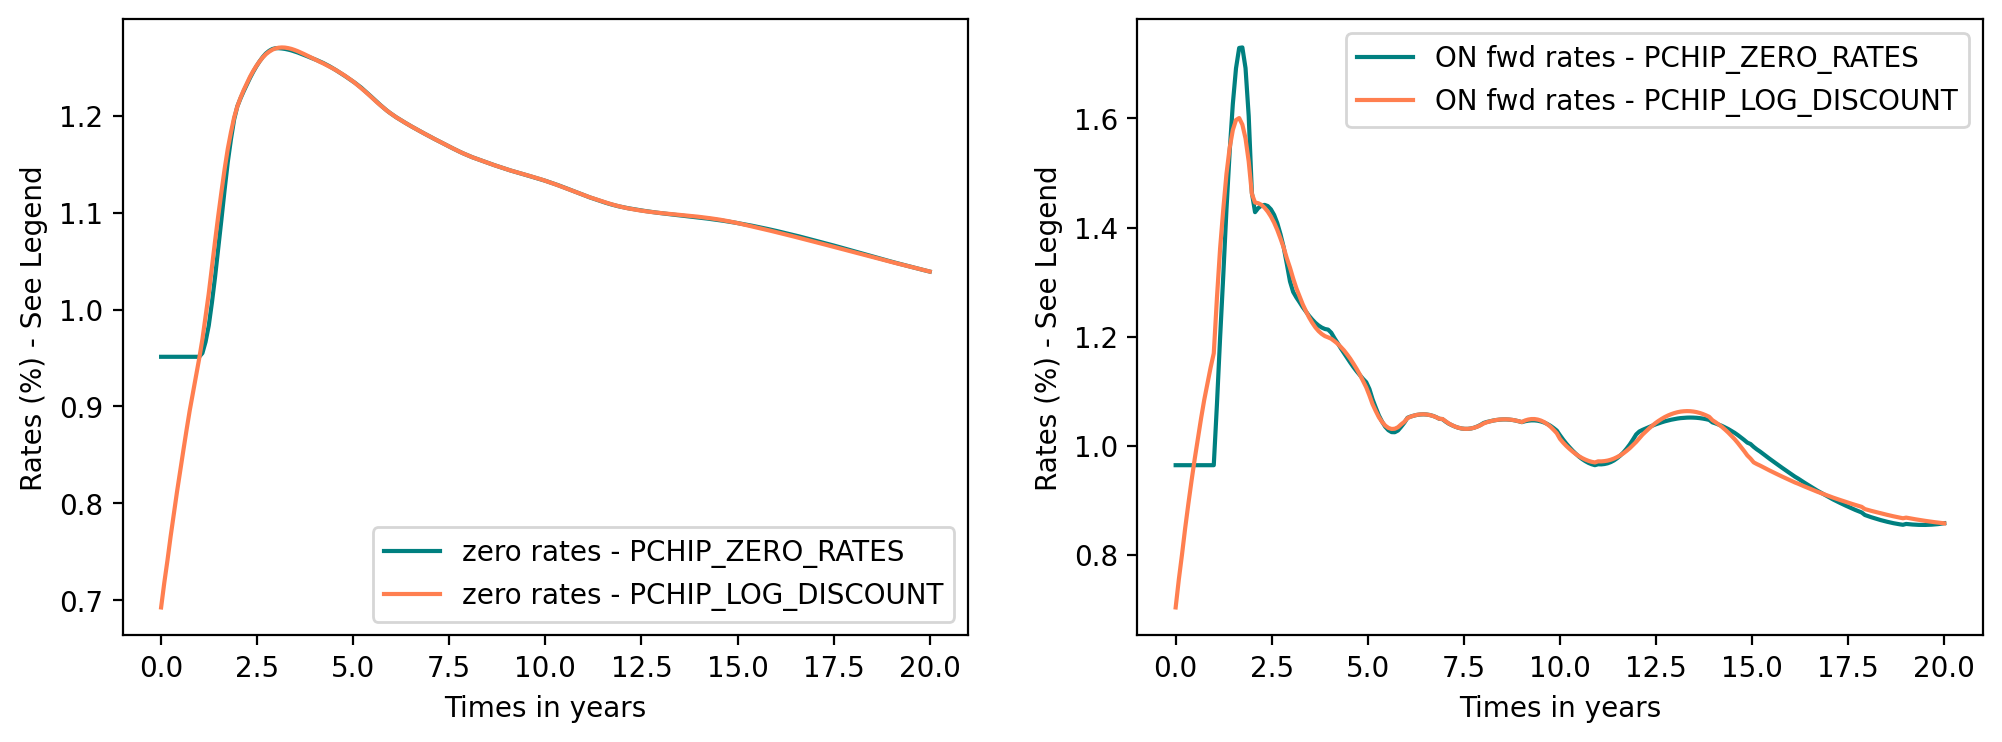

In [13]:
%config InlineBackend.figure_format='retina'

instr_mat_dates_or_tenor = '1Y'
start_date = valuation_date
tmax = 20

years = np.linspace(1/365, tmax, int(365*tmax)//30) # split the time into 30 day intervals
dates = start_date.add_years(years) # the array of end dates for the curve
ys_monthly = np.arange(1,tmax*12+1)/12
monthly_dates = start_date.add_years(ys_monthly)

neg_tenor = '-' + instr_mat_dates_or_tenor
start_fwd_dates = [d.add_tenor(neg_tenor) for d in dates]
start_fwd_dates = [d if d > start_date else start_date for d in start_fwd_dates]
fwd_rate_label = f'term fwd rates for [d-{instr_mat_dates_or_tenor},d]'

curve1 = IborSingleCurve(valuation_date, ibor_deposits = [], ibor_fras = [] , ibor_swaps = swaps, interp_type = InterpTypes.PCHIP_ZERO_RATES)
zero_rates1 = curve1.zero_rate(dates) # zero_rate
on_fwd_rates1 = curve1.fwd(dates) # ON fwd rates
term_fwd_rates2 = curve1.fwd_rate(start_fwd_dates, dates)

curve2 = IborSingleCurve(valuation_date, ibor_deposits = [], ibor_fras = [] , ibor_swaps = swaps, interp_type = InterpTypes.PCHIP_LOG_DISCOUNT)
zero_rates2 = curve2.zero_rate(dates) # zero_rate
on_fwd_rates2 = curve2.fwd(dates) # ON fwd rates
term_fwd_rates2 = curve2.fwd_rate(start_fwd_dates, dates)

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].plot(years, zero_rates1*100, '-', label="zero rates - PCHIP_ZERO_RATES", color='teal')
ax[0].plot(years, zero_rates2*100, '-', label="zero rates - PCHIP_LOG_DISCOUNT", color='coral')
ax[0].legend()
ax[0].set_xlabel("Times in years")
ax[0].set_ylabel("Rates (%) - See Legend")
ax[1].plot(years, on_fwd_rates1*100, '-', label = "ON fwd rates - PCHIP_ZERO_RATES", color='teal')
ax[1].plot(years, on_fwd_rates2*100, '-', label = "ON fwd rates - PCHIP_LOG_DISCOUNT", color='coral')
ax[1].legend()
ax[1].set_xlabel("Times in years")
ax[1].set_ylabel("Rates (%) - See Legend")
plt.savefig('curve_comparison_first_day.png', dpi=200)

Last day

In [14]:
# Demonstrate fitting a curve using the first date
valuation_date = Date(df.index[-1].day, df.index[-1].month, df.index[-1].year)
spot_days = 0 # T+0 as shown in Bloomberg ticker
settlement_date = valuation_date.add_weekdays(spot_days)
cal = CalendarTypes.UNITED_KINGDOM
# store SONIA swap as we only have swap as benchmark instruments
swaps = []
swapType = SwapTypes.PAY # pay fixed
fixedDCCType = DayCountTypes.ACT_365F # 365 fixed
fixedFreqType = FrequencyTypes.ANNUAL # annual
floatFreqType = FrequencyTypes.ANNUAL # annual
floatDCCType = DayCountTypes.ACT_365F # 365 fixed

# Only use years
for tenor in df.columns:
   if tenor[-1]=='Y': # only ap}pend yearly tenors for swap
      rate = df.loc[df.index[-1], tenor]/100 # convert to %
      swap = IborSwap(effective_date=settlement_date, termination_date_or_tenor=tenor,
                      fixed_leg_type=swapType, fixed_coupon=rate, fixed_freq_type=fixedFreqType, fixed_day_count_type=fixedDCCType,
                      float_freq_type=floatFreqType, float_day_count_type=floatDCCType, calendar_type=cal)
      swaps.append(swap)


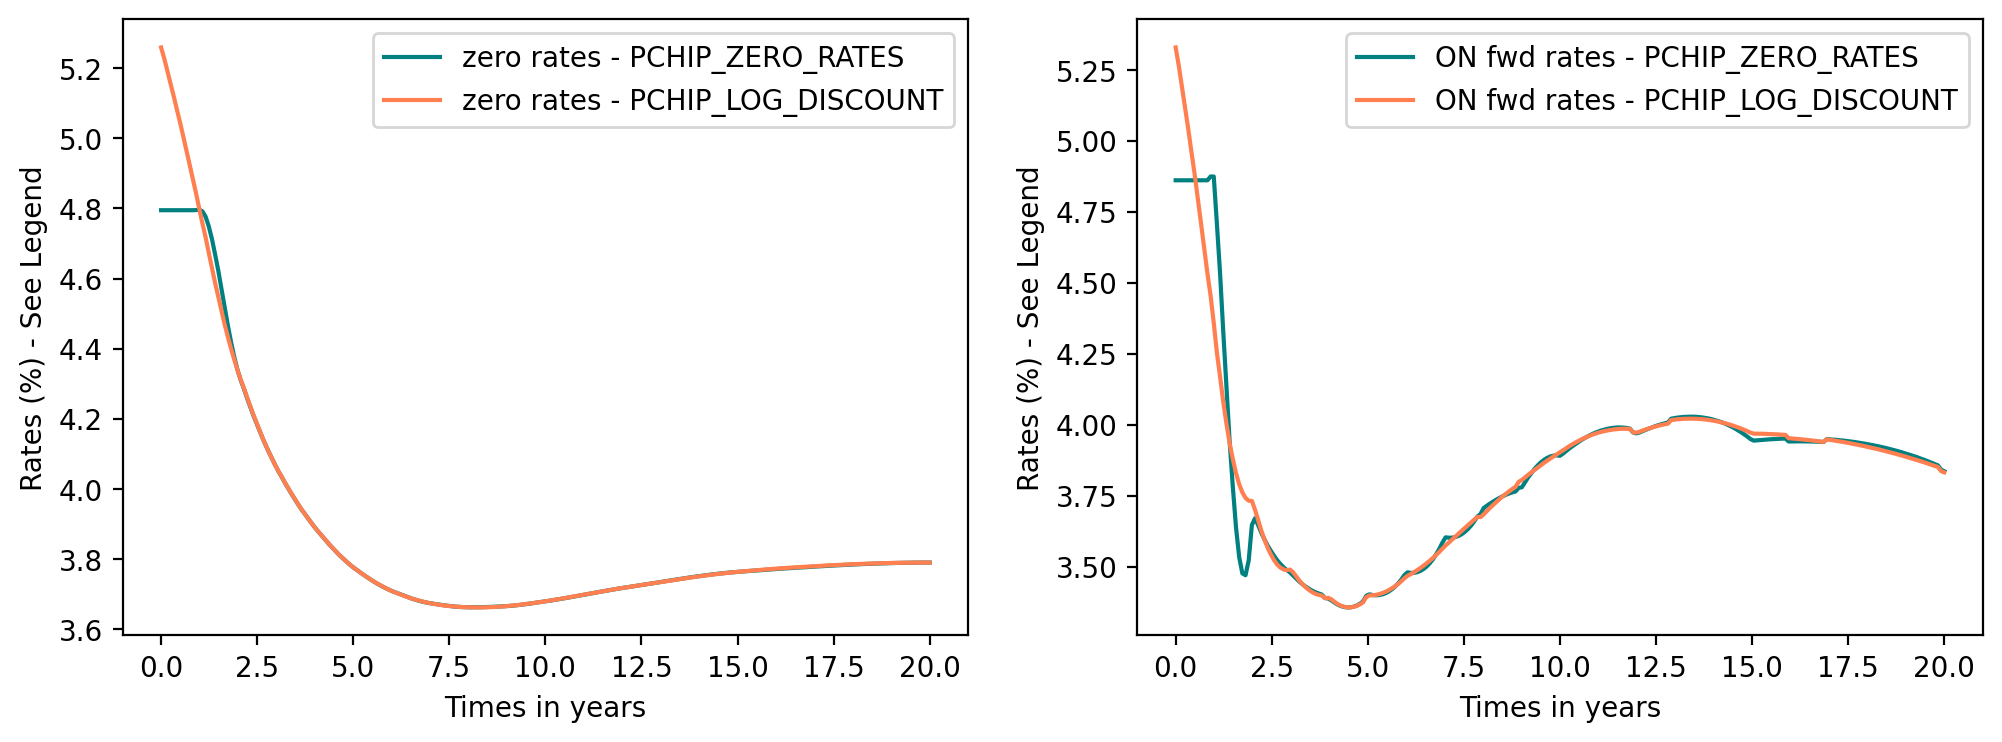

In [15]:
%config InlineBackend.figure_format='retina'

instr_mat_dates_or_tenor = '1Y'
start_date = valuation_date
tmax = 20

years = np.linspace(1/365, tmax, int(365*tmax)//30) # split the time into 30 day intervals
dates = start_date.add_years(years) # the array of end dates for the curve
ys_monthly = np.arange(1,tmax*12+1)/12
monthly_dates = start_date.add_years(ys_monthly)

neg_tenor = '-' + instr_mat_dates_or_tenor
start_fwd_dates = [d.add_tenor(neg_tenor) for d in dates]
start_fwd_dates = [d if d > start_date else start_date for d in start_fwd_dates]
fwd_rate_label = f'term fwd rates for [d-{instr_mat_dates_or_tenor},d]'

curve1 = IborSingleCurve(valuation_date, ibor_deposits = [], ibor_fras = [] , ibor_swaps = swaps, interp_type = InterpTypes.PCHIP_ZERO_RATES)
zero_rates1 = curve1.zero_rate(dates) # zero_rate
on_fwd_rates1 = curve1.fwd(dates) # ON fwd rates
term_fwd_rates2 = curve1.fwd_rate(start_fwd_dates, dates)

curve2 = IborSingleCurve(valuation_date, ibor_deposits = [], ibor_fras = [] , ibor_swaps = swaps, interp_type = InterpTypes.PCHIP_LOG_DISCOUNT)
zero_rates2 = curve2.zero_rate(dates) # zero_rate
on_fwd_rates2 = curve2.fwd(dates) # ON fwd rates
term_fwd_rates2 = curve2.fwd_rate(start_fwd_dates, dates)

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].plot(years, zero_rates1*100, '-', label="zero rates - PCHIP_ZERO_RATES", color='teal')
ax[0].plot(years, zero_rates2*100, '-', label="zero rates - PCHIP_LOG_DISCOUNT", color='coral')
ax[0].legend()
ax[0].set_xlabel("Times in years")
ax[0].set_ylabel("Rates (%) - See Legend")
ax[1].plot(years, on_fwd_rates1*100, '-', label = "ON fwd rates - PCHIP_ZERO_RATES", color='teal')
ax[1].plot(years, on_fwd_rates2*100, '-', label = "ON fwd rates - PCHIP_LOG_DISCOUNT", color='coral')
ax[1].legend()
ax[1].set_xlabel("Times in years")
ax[1].set_ylabel("Rates (%) - See Legend")
plt.savefig('curve_comparison_last_day.png', dpi=200)

## Post-PCA Corr Plots

In [16]:
with open('df_yield.pkl', 'rb') as f:
    df_yield = pickle.load(f)
df_yield = df_yield.astype(np.float32)
# convert outwright yield to change in yield
df_changes = df_yield.diff()
df_changes.dropna(inplace=True)

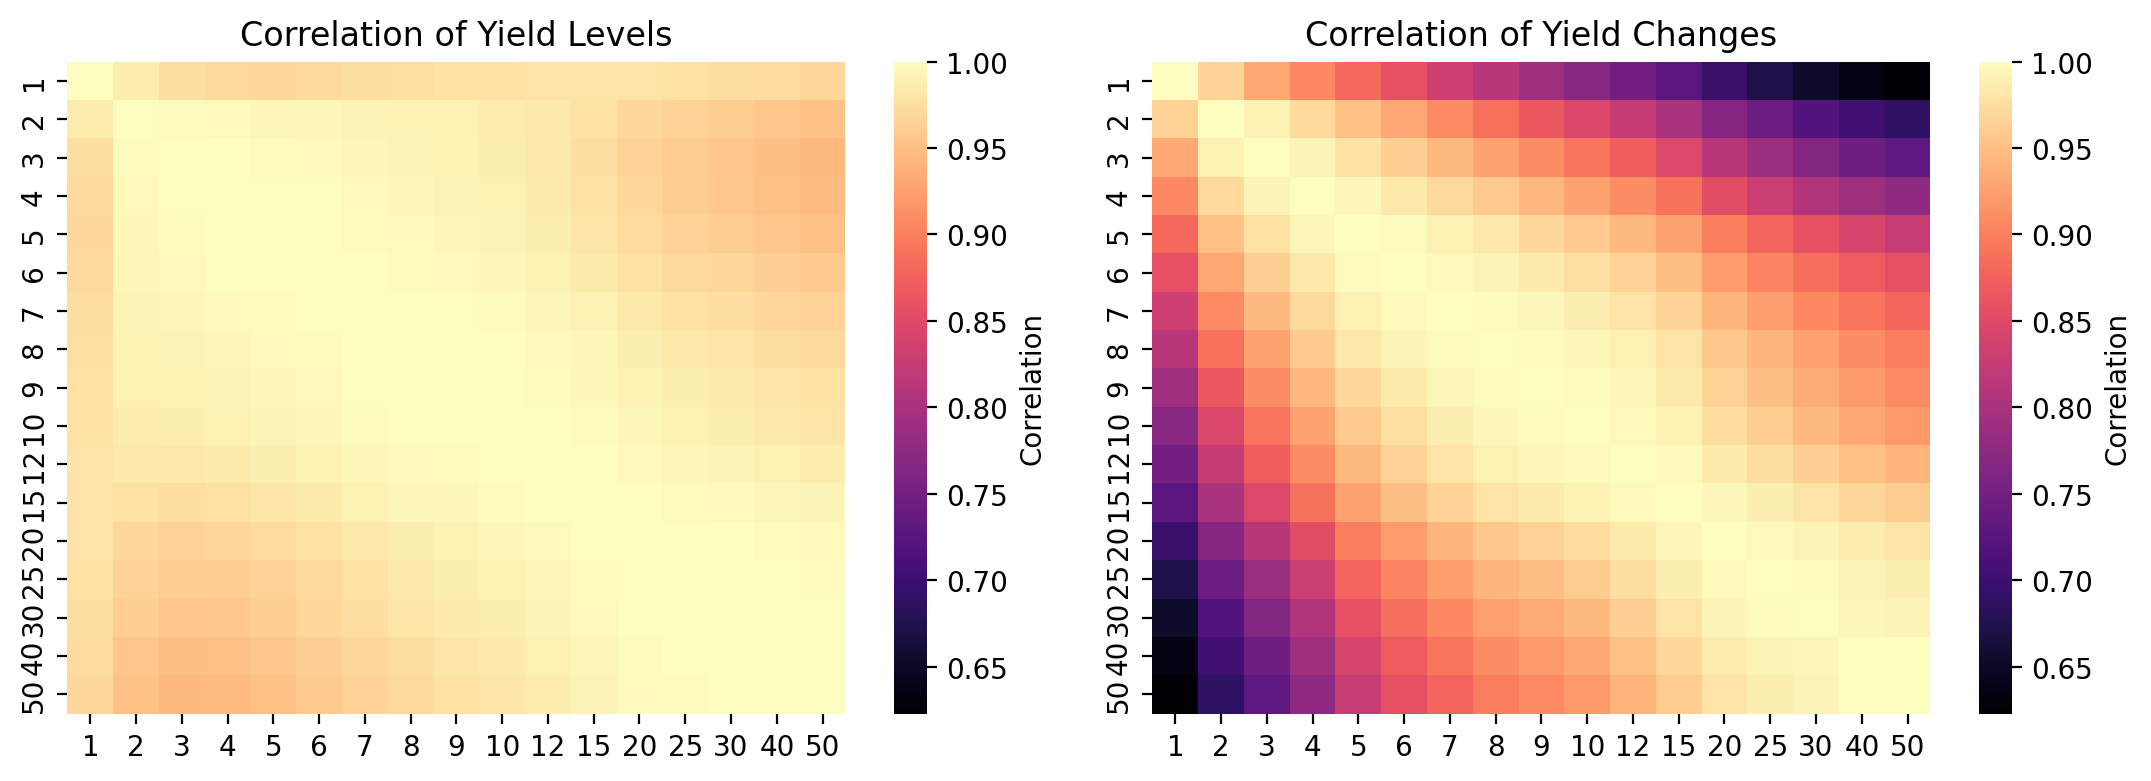

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

correlation_yield = df_yield.corr()
correlation_changes = df_changes.corr()
vmax = max(correlation_yield.max().max(), correlation_changes.max().max())
vmin = min(correlation_yield.min().min(), correlation_changes.min().min())

# Set up the matplotlib figure
fig, ax = plt.subplots(1, 2, figsize=(11,4))

# Generate the heatmaps
cmap = "magma"
heatmap(correlation_yield, ax=ax[0], annot=False, cmap=cmap, cbar_kws={'label': 'Correlation'},
        vmin=vmin, vmax=vmax)
ax[0].set_title('Correlation of Yield Levels')

heatmap(correlation_changes, ax=ax[1], annot=False, cmap=cmap, cbar_kws={'label': 'Correlation'},
        vmin=vmin, vmax=vmax)
ax[1].set_title('Correlation of Yield Changes')

# Display the plot
plt.tight_layout()
plt.show()
fig.savefig('corr_comparison.png', dpi=200)